# Import Packages

In [1]:
import pandas as pd
import os
import glob
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point, Polygon

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import make_pipeline

# Import miscellaneous files and define functions

In [2]:
# Function for calculating euclidean distance
def EuclideanDistCald(bp1xVals, bp1yVals, bp2xVals, bp2yVals, currPixPerMM):
        series = (np.sqrt((bp1xVals - bp2xVals) ** 2 + (bp1yVals - bp2yVals) ** 2)) / currPixPerMM
        return series

# Import video info file containing pixels/mm for each video
video_info = pd.read_csv('video_info.csv')

# Import feat_dict file containing dictionary with general categories for large feature dataset
with open('feat_dict.json') as json_file:
    data = json.load(json_file)
data

{'adult_body_points': ['nose_x',
  'nose_y',
  'head_center_x',
  'head_center_y',
  'ear_left_x',
  'ear_left_y',
  'ear_right_x',
  'ear_right_y',
  'neck_x',
  'neck_y',
  'side_left_x',
  'side_left_y',
  'side_right_x',
  'side_right_y',
  'body_center_x',
  'body_center_y',
  'hip_left_x',
  'hip_left_y',
  'hip_right_x',
  'hip_right_y',
  'tailbase_x',
  'tailbase_y',
  'tail_tip_x',
  'tail_tip_y',
  'tail_center_x',
  'tail_center_y',
  'tail_upper_x',
  'tail_upper_y',
  'tail_lower_x',
  'tail_lower_y'],
 'adult_body_prob': ['nose_p',
  'head_center_p',
  'ear_left_p',
  'ear_right_p',
  'neck_p',
  'side_left_p',
  'side_right_p',
  'body_center_p',
  'hip_left_p',
  'hip_right_p',
  'tailbase_p',
  'tail_tip_p',
  'tail_center_p',
  'tail_upper_p',
  'tail_lower_p'],
 'infant_and_nest_points': ['Infant1_head_x',
  'Infant1_head_y',
  'Infant1_middle_head_x',
  'Infant1_middle_head_y',
  'Infant1_middle_tail_x',
  'Infant1_middle_tail_y',
  'Infant1_tail_x',
  'Infant1_tai

# Import feature dataframes

In [3]:
%%time
# Define feature directory
features_directory = 'targets_inserted'
file_location = os.path.join(features_directory, '*.csv')

# create list of filenames for every video to be processed
# this list is the input for the video processing function
filenames = glob.glob(file_location)
videoname = []
for f in filenames:
    # establish name for output file from the input filename
    x = os.path.split(f)
    x = f
    videoname.append(x)
videoname

Wall time: 1 ms


['targets_inserted\\Gal_35_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_37_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_38_mother_retreive_trial_1.csv',
 'targets_inserted\\Gal_49_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Gal_60_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_52_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_53_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv']

In [4]:
%%time
# Read in the csv file for each feature dataframe
dfs = []
for x in videoname:
    filepath = x
    features = pd.read_csv(filepath)
    features['videoname'] = pd.Series([x] * (len(features)))
    dfs.append(features)
    print(len(dfs))

1
2
3
4
5
6
7
8
9
Wall time: 1min 15s


# Extract infant specific features

In [5]:
%%time

# Define an empty dataframe
df = pd.DataFrame()

# Define empty lists that will be used later in this block
videos = []
feature_vals = []
feature_index = []
start_retrieve = []
end_retrieve = []
infs_nest_rates = []
infs_movements = []

# Loop through all the feature dataframes
for i in range(len(dfs)):
    
    feats_cat = dfs[i]
    
    # Find the rate at which the distance between the adult and the infant changes, summed over 90 frames with
    # the present frame in the middle of the 90 frame window
    inf1_nest = feats_cat['Inf1_points_avg_to_nest_centroid_home']
    inf2_nest = feats_cat['Inf2_points_avg_to_nest_centroid_home']

    inf1_nest_shifted = inf1_nest.shift(periods=1)
    inf1_nest_shifted = inf1_nest_shifted.fillna(0)
    inf2_nest_shifted = inf2_nest.shift(periods=1)
    inf2_nest_shifted = inf2_nest_shifted.fillna(0)

    inf1_nest_rate = pd.Series(inf1_nest.values - inf1_nest_shifted.values)
    inf1_nest_rate_summed = pd.Series(inf1_nest_rate.rolling(90, min_periods=1, center=True).sum())
    inf2_nest_rate = pd.Series(inf2_nest.values - inf2_nest_shifted.values)
    inf2_nest_rate_summed = pd.Series(inf2_nest_rate.rolling(90, min_periods=1, center=True).sum())

    infs_nest_rate_summed = inf1_nest_rate_summed + inf2_nest_rate_summed
    infs_nest_rates.append(infs_nest_rate_summed)
    
    # Find the total movement of all infant body points, summed over 90 frames with
    # the present frame in the middle of the 90 frame window 
    infs_movement = dfs[i]['Total_movement_infants']
    infs_movement_summed = pd.Series(infs_movement.rolling(90, min_periods=1, center=True).sum())
    infs_movements.append(infs_movement_summed)
    
    # Use the manual retrieval annotations to make a list of 0's and 1's, a 0 being when retrieval is not occurring
    # and a 1 being when retrieval is occurring
    retrieval_bouts = []
    retrieval = feats_cat['successful_retrieval'].astype(int)
    for j in range(len(retrieval)):
        if j == 0 or j == len(retrieval) - 1:
            continue
        else:
            if retrieval[j] == 1 and retrieval[j - 1] == 0:
                retrieval_bout = [j]
            if retrieval[j] == 1 and retrieval[j - 1] == 1:
                retrieval_bout.append(j)
            if retrieval[j] == 0 and retrieval[j - 1] == 1:
                retrieval_bouts.append(retrieval_bout)
     
    # Choose a feature to plot
    feature = infs_nest_rate_summed
    
    # Loop through the retrieval bouts list to determine the frames in a video in which retrieval starts and the
    # frames in a video in which retrieval ends
    for j in range(len(retrieval_bouts)):
        feature_retrieval = feature[retrieval_bouts[j][0] - 500:
                                                    retrieval_bouts[j][len(retrieval_bouts[j]) - 1] + 501]
        
        feature_vals.append(feature_retrieval)
        feature_index.append(feature_retrieval.index)
        videos.append(videoname[i])
        start_retrieve.append(retrieval_bouts[j][0])
        end_retrieve.append(retrieval_bouts[j][len(retrieval_bouts[j]) - 1])
        
# Code to produce a plot of the chosen feature against the ground truth retrieval occurrences        
        #plt.figure(figsize=(10,6))
        #plt.plot(feature_retrieval.index, feature_retrieval, 
        #         label='summed slopes of infant-nest distance (90 frames)')
        #plt.axvline(retrieval_bouts[j][0], label='start of labeled retrieval', color='orange')
        #plt.axvline(retrieval_bouts[j][len(retrieval_bouts[j]) - 1], label='end of labeled retrieval', color='orange')
        #plt.legend(bbox_to_anchor=(1, 0.5))
        #plt.show()
#fig, ax = plt.subplots(2, 4, sharey=True, figsize=(15,6))
#plt.figure(figsize=(15,6))
#for i in range(len(videos)):
#    plt.subplot(2, 4, i + 1)
#    plt.plot(feature_index[i], feature_vals[i], label='summed slopes of infant-nest distance (90 frames)')
#    plt.axvline(start_retrieve[i], label='start of labeled retrieval', color='orange')
#    plt.axvline(end_retrieve[i], label='end of labeled retrieval', color='orange')
#    plt.title(videos[i][17:-4])
#    plt.ylim([-25, 10])

#plt.legend(bbox_to_anchor=(1, -0.5))
#plt.subplots_adjust(hspace=0.5)

Wall time: 10.6 s


In [18]:
videos

['targets_inserted\\Gal_35_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_35_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_37_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_49_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Gal_60_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_52_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_53_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_53_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targe

0 targets_inserted\Gal_35_father_retreive_trial_1.csv
1 targets_inserted\Gal_35_father_retreive_trial_1.csv
2 targets_inserted\Gal_37_father_retreive_trial_1.csv
3 targets_inserted\Gal_49_virginfemale_retreive_trial_1.csv
4 targets_inserted\Gal_60_virginfemale_retreive_trial_1.csv
5 targets_inserted\Ucn3_50_father_retreive_trial_1.csv
6 targets_inserted\Ucn3_50_father_retreive_trial_1.csv
7 targets_inserted\Ucn3_52_mother_retreive_trial_1.csv
8 targets_inserted\Ucn3_53_mother_retreive_trial_1.csv
9 targets_inserted\Ucn3_53_mother_retreive_trial_1.csv
10 targets_inserted\Ucn3_54_father_retreive_trial_1.csv
11 targets_inserted\Ucn3_54_father_retreive_trial_1.csv


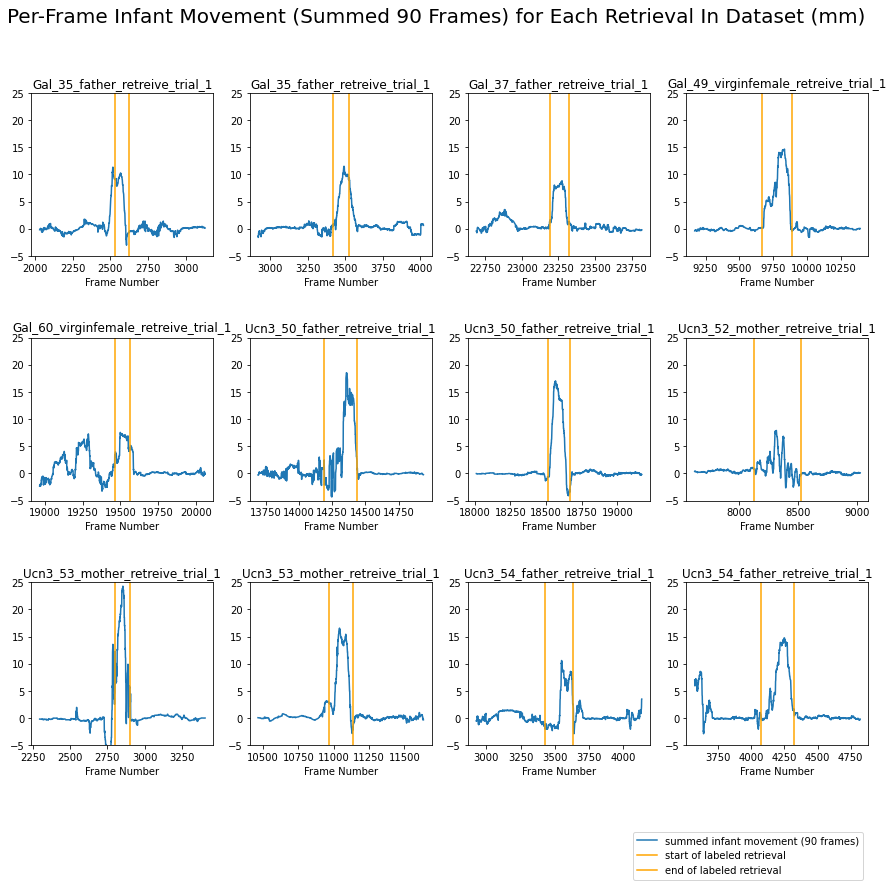

In [12]:
for i in range(len(dfs)):
    for j in range(len(retrieval_bouts)):
        feature_retrieval = infs_movements[retrieval_bouts[j][0] - 500:
                                                    retrieval_bouts[j][len(retrieval_bouts[j]) - 1] + 501]
        
        feature_vals.append(feature_retrieval)
        feature_index.append(feature_retrieval.index)
        videos.append(videoname[i])
        start_retrieve.append(retrieval_bouts[j][0])
        end_retrieve.append(retrieval_bouts[j][len(retrieval_bouts[j]) - 1])
        
# Code to produce a plot of the chosen feature against the ground truth retrieval occurrences        
        #plt.figure(figsize=(10,6))
        #plt.plot(feature_retrieval.index, feature_retrieval, 
        #         label='summed slopes of infant-nest distance (90 frames)')
        #plt.axvline(retrieval_bouts[j][0], label='start of labeled retrieval', color='orange')
        #plt.axvline(retrieval_bouts[j][len(retrieval_bouts[j]) - 1], label='end of labeled retrieval', color='orange')
        #plt.legend(bbox_to_anchor=(1, 0.5))
        #plt.show()

#fig, ax = plt.subplots(3, 4, sharey=True, figsize=(15,12))
#fig.suptitle('Per-frame Change in Infant-Nest Distance (Summed 90 Frames)')
plt.figure(figsize=(15,12))
for i in range(len(videos)):
    if i > 11:
        continue
    print(i, videos[i])
    plt.subplot(3, 4, i + 1)
    plt.plot(feature_index[i], -feature_vals[i], label='summed infant movement (90 frames)')
    plt.axvline(start_retrieve[i], label='start of labeled retrieval', color='orange')
    plt.axvline(end_retrieve[i], label='end of labeled retrieval', color='orange')
    plt.title(videos[i][17:-4])
    plt.ylim([-5, 25])
    plt.xlabel('Frame Number')
    if i == 11:
        plt.legend(bbox_to_anchor=(1, -0.5))
plt.legend(bbox_to_anchor=(1, -0.5))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Per-Frame Infant Movement (Summed 90 Frames) for Each Retrieval In Dataset (mm)', fontsize=20)
plt.show()

# 'Loop' feature based on pup fill-in points script

In [9]:
%%time
# Start a list for when an infants point 'disappears'
bp_disappear = []
bp_reappear = []

# Loop through the infant body point probabilities (in this case only middle_head)
for bp in ['_middle_head_p']:
    
    # Make lists that will contain dictionaries for the frames in which an infant 'disappears' and one for when it
    # 'reappears' (each dictionary is for a specific video)
    columns_disappear_all = []
    columns_reappear_all = []

    # Find all the occurences of disappearances for each infant
    for i in range(len(dfs)):
        # Dictionaries for occurences of disappearance for each infant
        columns_disappear = {'Infant1': [], 'Infant2': []}
        columns_reappear = {'Infant1': [], 'Infant2': []}
        df = dfs[i]
        for num in range(1, 3):
            disappear = []
            reappear = []
            for j in range(len(dfs[i])):
                prob_index = df['Infant' + str(num) + bp].index
                if df['Infant' + str(num) + bp][j] == 0.01:
                    if j - 1 not in prob_index:
                        continue
                    if df['Infant' + str(num) + bp][j - 1] != .01:
                        disappear.append(j)
                    if j + 1 not in prob_index:
                        disappear.pop(-1)
                        continue
                    if df['Infant' + str(num) + bp][j + 1] != .01:
                        reappear.append(j)
            if len(disappear) > len(reappear):
                    disappear.pop(-1)
            if num == 1:
                columns_disappear['Infant1'] = disappear
                columns_reappear['Infant1'] = reappear
            else: 
                columns_disappear['Infant2'] = disappear
                columns_reappear['Infant2'] = reappear
        columns_disappear_all.append(columns_disappear)
        columns_reappear_all.append(columns_reappear)
    bp_disappear.append(columns_disappear_all)
    bp_reappear.append(columns_reappear_all)

Wall time: 12.5 s


In [10]:
%%time
# Find the retrieval occurrences based on infant disappearance
bp_retrieve_loops = {}
bp_list = ['_middle_head']
for bp in range(len(bp_list)):
    columns_disappear_all = bp_disappear[bp]
    columns_reappear_all = bp_reappear[bp]
    videos = []
    retrieval_windows = []
    retrieve_starts = []
    retrieve_ends = []
    # from 01_SW_Infants_add_missing_points
    for i in range(len(dfs)):
        columns_disappear = columns_disappear_all[i]
        columns_reappear = columns_reappear_all[i]
        for key in columns_disappear:
            for j in range(len(columns_disappear[key])):

                # Check if each list in columns_disappear is empty, and if so skip
                if columns_disappear[key] == []:
                    continue

                # Find the difference between the value each point in each list of columns_reappear 
                #with the corresponding point in the corresponding list of columns_disappear

                difference_x = (dfs[i][key + bp_list[bp] + '_x'][columns_disappear[key][j]] - 
                                dfs[i][key + bp_list[bp] + '_x'][columns_reappear[key][j]])
                difference_y = (dfs[i][key + bp_list[bp] + '_y'][columns_disappear[key][j]] - 
                                dfs[i][key + bp_list[bp] + '_y'][columns_reappear[key][j]])

                # If the difference is above a certain threshold, call it retrieval by adding the start and end
                # frames to columns_disappear and columns_reappear
                if (abs(difference_x) > 100) or (abs(difference_y) > 100):
            
                    for l in range(columns_disappear[key][j], columns_reappear[key][j]):
                        end_diff_head_x = abs(dfs[i][key + bp_list[bp] + '_x'][columns_reappear[key][j]] - 
                                              dfs[i]['head_center_x'][l])
                        end_diff_head_y = abs(dfs[i][key + bp_list[bp] + '_y'][columns_reappear[key][j]] - 
                                              dfs[i]['head_center_y'][l])
                        if end_diff_head_x < 30 and end_diff_head_y < 15:
                            if not (columns_disappear[key][j]) in retrieve_starts:
                                    retrieve_starts.append(columns_disappear[key][j])
                                    retrieve_ends.append(l)
                                    videos.append(videoname[i])
                                    
    # Create a list containing the numbers of the frames in which retrieval is occurring
    for i in range(len(retrieve_starts)):

        retrieval_window = [*range(retrieve_starts[i], retrieve_ends[i], 1)]
        retrieval_windows.append(retrieval_window)
    
    bp_retrieve_loops[bp_list[bp]] = retrieval_windows
    

Wall time: 760 ms


In [11]:
bp_retrieve_detections = {}
# Make a list based on retrieval loop lists, where the list is the length of the video being looked at, and all
# the frames in which a retrieval loop detection is occurring is labeled 1 and when it's not happending it's labeled
# as 0
for key in bp_retrieve_loops:
    retrieval_windows = bp_retrieve_loops[key]
    retrieve_detections = []
    for i in range(len(videoname)):
        video_index_current = videos.index(videoname[i])
        if i < len(videoname) - 1:
            video_index_next = videos.index(videoname[i + 1])
        else:
            video_index_next = len(videos) - 1
        retrieve_detection = np.zeros(len(dfs[i]))
        for j in range(video_index_current,video_index_next):
            retrieve_detection[retrieval_windows[j][0]:retrieval_windows[j][len(retrieval_windows[j]) - 1]] = 1

        retrieve_detections.append(pd.Series(retrieve_detection))
    bp_retrieve_detections[key] = retrieve_detections

In [1]:
# Block for creating a plot of when the retrieve loop detection is occurring compared to ground truth retrieval
# annotations

#fig, ax = plt.subplots(1, 5, sharey=True, figsize=(15,6))

#for i in range(len(videos)):
    
#    if i + 1 < len(videos):
#        if videos[i + 1] == videos[i]:
#            if retrieval_windows[i] > retrieval_windows[i + 1]:
#                retrieval_windows[i], retrieval_windows[i + 1] = retrieval_windows[i + 1], retrieval_windows[i]
                
#    fill_in_points_retrieval = pd.Series(np.ones(len(retrieval_windows[i])))
#    fill_in_points_retrieval.index = retrieval_windows[i]
#    zeros1 = pd.Series(np.zeros(500))
#    zeros1.index = [*range(retrieval_windows[i][0] - 500, retrieval_windows[i][0], 1)]
#    zeros2 = pd.Series(np.zeros(500))
#    zeros2.index = ([*range(retrieval_windows[i][(len(retrieval_windows[i])) - 1] + 1, 
                            retrieval_windows[i][(len(retrieval_windows[i])) - 1] + 501, 1)])
#    plot_window = pd.concat([zeros1, fill_in_points_retrieval, zeros2])
    
    
    
#    plt.subplot(1, 5, i + 1)
#    plt.plot(plot_window.index, plot_window, 
#             label='fill in points retrieval')
#    plt.axvline(start_retrieve[0], label='start of labeled retrieval', color='orange')
#    plt.axvline(end_retrieve[0], label='end of labeled retrieval', color='orange')
#    plt.title(videos[i][17:-4])
#plt.legend(bbox_to_anchor=(1, -0.2))
#plt.subplots_adjust(hspace=0.5)

NameError: name 'videos' is not defined

# Adult specific features

In [6]:
# Make dictionaries to contain feature information for each video
video_areas = {}
video_circularities = {}
video_adult_nest = {}
ppm = video_info['pixels/mm'][0]

for i in range(len(dfs)):
    
    # Make empty lists for video-specific feature info
    areas = []
    circularities = []
    center_xs = []
    center_ys = []
    
    df = dfs[i][data['adult_body_points']]
    nest_info = dfs[i][data['infant_and_nest_points']]
    
    # Make hull of adult body for each frame, then find the area and circularity of the hull for each frame
    for j in range(len(df)):
        
        p1 = Point(df['head_center_x'][j], df['head_center_y'][j])
        p2 = Point(df['ear_right_x'][j], df['ear_right_y'][j])
        p3 = Point(df['side_right_x'][j], df['side_right_y'][j])
        p4 = Point(df['hip_right_x'][j], df['hip_right_y'][j])
        p5 = Point(df['hip_left_x'][j], df['hip_left_y'][j])
        p6 = Point(df['side_left_x'][j], df['side_left_y'][j])
        p7 = Point(df['ear_left_x'][j], df['ear_left_y'][j])
        
        polygon = Polygon([p1, p2, p3, p4, p5, p6, p7])
        
        area = polygon.area
        areas.append(area)
        
        circularity = (4 * np.pi) * area / (polygon.length) ** 2
        circularities.append(circularity)
        
        center_x = polygon.centroid.x
        center_xs.append(center_x)
        center_y = polygon.centroid.y
        center_ys.append(center_y)
        
    video_areas[videoname[i]] = pd.Series(areas / (ppm ** 2))
    video_circularities[videoname[i]] = pd.Series(circularities)
    
    # Find change in distances between the adult and nest, summed over 90 frames, where the present frame is in the
    # middle of the 90 frame window
    center_xs = np.array(center_xs)
    center_ys = np.array(center_ys)
    nest_xs = nest_info['nest_centroid_home_x'].values
    nest_ys = nest_info['nest_centroid_home_y'].values
    
    adult_nest_dist = EuclideanDistCald(center_xs, center_ys, nest_xs, nest_ys, ppm)
    adult_nest_dist = pd.Series(adult_nest_dist)
    adult_nest_shifted = adult_nest_dist.shift(periods=1)
    adult_nest_shifted = adult_nest_shifted.fillna(0)
    adult_nest_rate = pd.Series(adult_nest_dist.values - adult_nest_shifted.values)
    adult_nest_rate_summed = pd.Series(adult_nest_rate.rolling(90, min_periods=1, center=True).sum())
    
    video_adult_nest[videoname[i]] = adult_nest_rate_summed

video_adult_nest

{'targets_inserted\\Gal_35_father_retreive_trial_1.csv': 0        3.260060
 1        3.245577
 2        3.253393
 3        3.250721
 4        3.250721
            ...   
 11646    5.670026
 11647    5.683625
 11648    5.206018
 11649    4.761437
 11650    4.767829
 Length: 11651, dtype: float64,
 'targets_inserted\\Gal_37_father_retreive_trial_1.csv': 0        7.416728
 1        7.416728
 2        7.408049
 3        7.428374
 4        7.414109
            ...   
 32378   -0.508104
 32379   -0.512411
 32380   -0.485360
 32381   -0.489961
 32382   -0.481494
 Length: 32383, dtype: float64,
 'targets_inserted\\Gal_38_mother_retreive_trial_1.csv': 0        4.370191
 1        4.358337
 2        4.343546
 3        4.346043
 4        4.315924
            ...   
 13951    0.131284
 13952    0.115306
 13953    0.118006
 13954    0.099775
 13955    0.099775
 Length: 13956, dtype: float64,
 'targets_inserted\\Gal_49_virginfemale_retreive_trial_1.csv': 0        12.156634
 1        12.169753
 2     

# Plot code for area, circularity, and adult-nest summed distance

ValueError: num must be 1 <= num <= 12, not 13

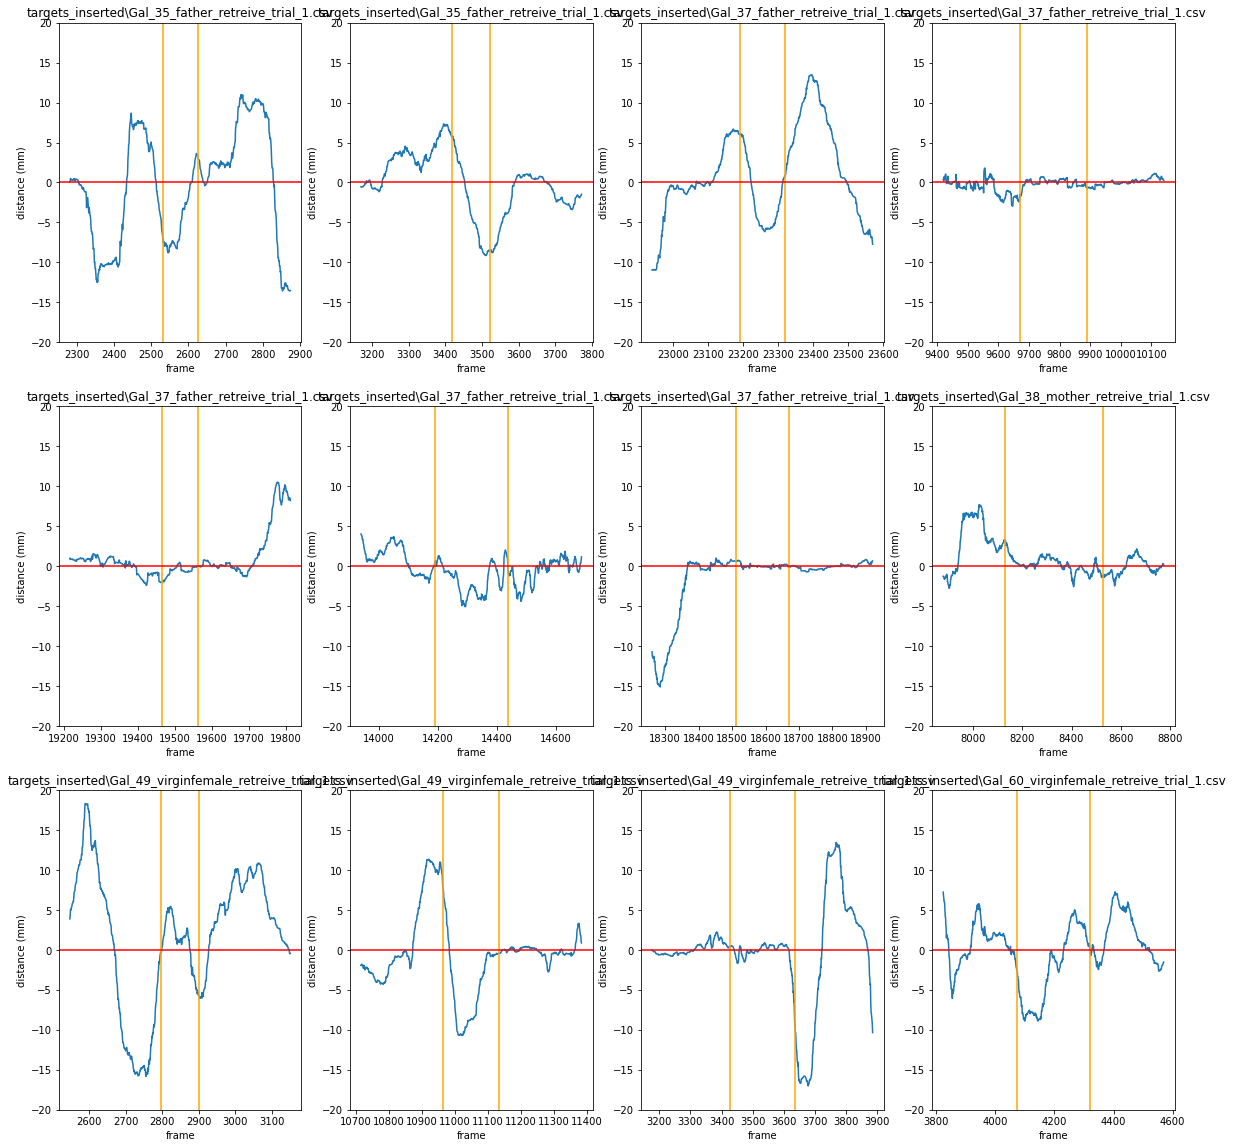

In [53]:
plt.subplots(3, 4, figsize=(20,20))
count = 1
for i in range(len(videos)):
    plt.subplot(3, 4, count)
    adult_nest = video_adult_nest[videos[i]][start_retrieve[i] - 250: end_retrieve[i] + 250]
    plt.plot(adult_nest.index, adult_nest, label='summed slopes of adult_nest_distance (90 frames)')
    plt.axvline(start_retrieve[i], label='start of labeled retrieval', color='orange')
    plt.axvline(end_retrieve[i], label='end of labeled retrieval', color='orange')
    plt.axhline(0, color='red')
    plt.xlabel('frame')
    plt.ylabel('distance (mm)')
    plt.title(videos[i])
    count += 1
    plt.ylim([-20, 20])
plt.legend(bbox_to_anchor=(1, -0.1))
plt.subplots_adjust(hspace=0.2)

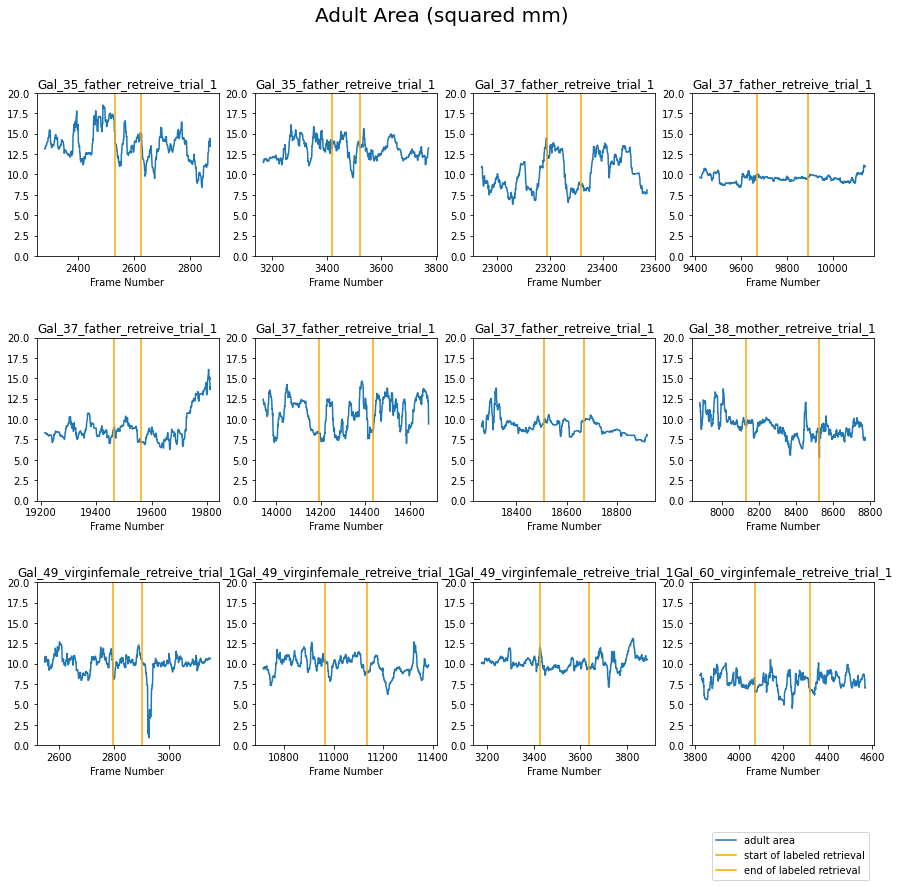

In [156]:
plt.subplots(3, 4, figsize=(15,12))
count = 1
for i in range(len(videos)):
    if i > 11:
        continue
    plt.subplot(3, 4, count)
    area = video_areas[videos[i]][start_retrieve[i] - 250: end_retrieve[i] + 250]
    plt.plot(area.index, area, label='adult area')
    plt.axvline(start_retrieve[i], label='start of labeled retrieval', color='orange')
    plt.axvline(end_retrieve[i], label='end of labeled retrieval', color='orange')
    plt.xlabel('Frame Number')
    #plt.ylabel('distance (mm)')
    plt.title(videos[i][17:-4])
    count += 1
    plt.ylim([0, 20])
    if i == 11:
        plt.legend(bbox_to_anchor=(1, -0.5))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Adult Area (squared mm)', fontsize=20)
plt.show()

In [7]:
videos

['targets_inserted\\Gal_35_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_35_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_37_father_retreive_trial_1.csv',
 'targets_inserted\\Gal_49_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Gal_60_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_52_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_53_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_53_mother_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv']

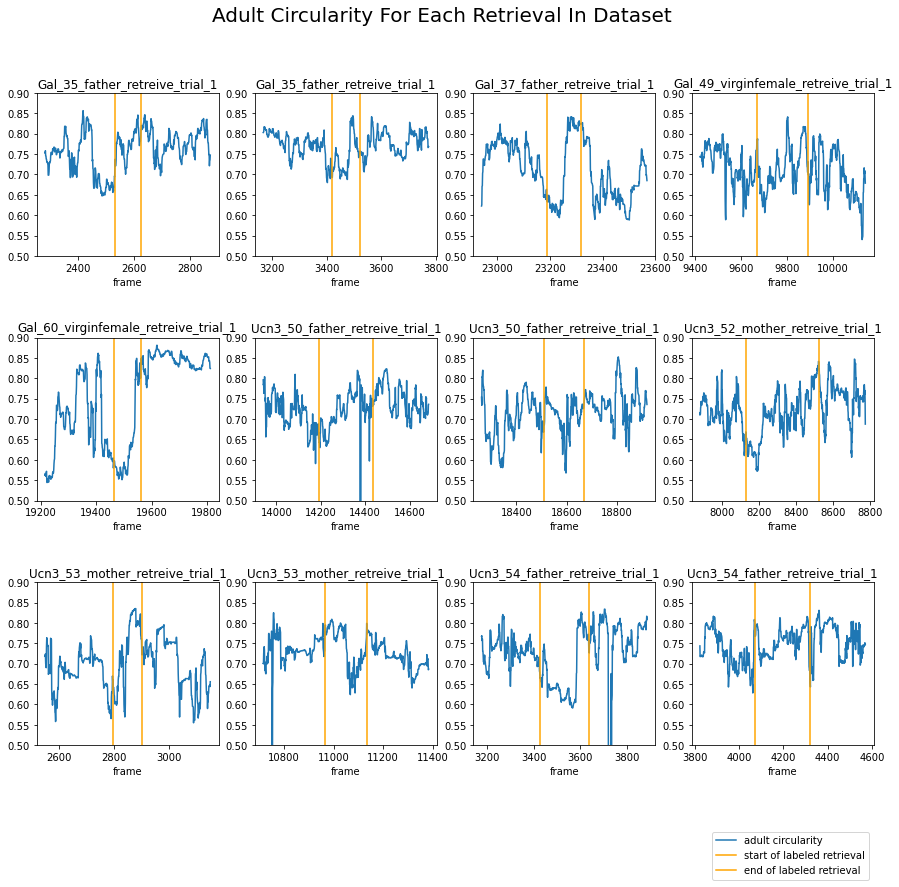

In [8]:
plt.subplots(3, 4, figsize=(15,12))
count = 1
for i in range(len(videos)):
    if i > 11:
        continue
    plt.subplot(3, 4, count)
    circularity = video_circularities[videos[i]][start_retrieve[i] - 250: end_retrieve[i] + 250]
    plt.plot(circularity.index, circularity, label='adult circularity')
    plt.axvline(start_retrieve[i], label='start of labeled retrieval', color='orange')
    plt.axvline(end_retrieve[i], label='end of labeled retrieval', color='orange')
    plt.xlabel('frame')
    plt.title(videos[i][17:-4])
    count += 1
    plt.ylim([0.5, 0.9])
    if i == 11:
        plt.legend(bbox_to_anchor=(1, -0.5))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Adult Circularity For Each Retrieval In Dataset', fontsize=20)
plt.show()

#  Euclidean distance PCA

In [12]:
for i in range(len(dfs)):
    # Get the point-to-point euclidean distances within the adult body for all the videos
    videoname_column = dfs[i]['videoname']
    euclid_dist = dfs[i][data['adult_distances']]
    if i == 0:
        euclid_dist_concat = euclid_dist
        videonames = videoname_column
    else:
        euclid_dist_concat = pd.concat([euclid_dist_concat, euclid_dist], ignore_index=True)
        videonames = pd.concat([videonames, videoname_column], ignore_index=True)

# Don't include any euclidean distances involving nose or tail points
for column in euclid_dist_concat.columns:
    if 'nose' in column or 'tail' in column:
        euclid_dist_concat = euclid_dist_concat.drop([column], axis=1)
    
# Calculate the PC's explaining 70% of the variance in adult euclidean distance data
scaler = StandardScaler()
scaled_euclid = scaler.fit_transform(euclid_dist_concat)
    
pca = PCA(0.7)
pca_euclid = pca.fit_transform(scaled_euclid)
euclid_dist_pca = pd.DataFrame(pca_euclid)

euclid_dist_pcas = []
euclid_dist_pca = pd.concat([euclid_dist_pca, videonames], axis=1)
for i in range(len(videoname)):
    video_pcas = euclid_dist_pca[euclid_dist_pca['videoname'] == videoname[i]]
    video_pcas = video_pcas.reset_index()
    video_pcas = video_pcas.drop(['videoname', 'index'], axis=1)
    euclid_dist_pcas.append(video_pcas)

# Code for general scree plot for PCA calculations
#    pca = PCA().fit(scaled_euclid)
#    PC_values = np.arange(pca.n_components_) + 1
#    plt.figure(figsize=(15,6))
#    plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=0.5)
#    plt.title('Scree Plot')
#    plt.xlabel('Principal Component')
#    plt.ylabel('Proportion of Variance Explained')
#    plt.show()
euclid_dist_pcas

[              0         1         2         3
 0      1.453783  2.445625 -2.330063  1.265103
 1      1.669864  2.579201 -2.370542  1.182606
 2      1.643785  2.564274 -2.374951  1.213910
 3      1.684602  2.553998 -2.369258  1.107515
 4      1.709068  2.588494 -2.390710  1.120022
 ...         ...       ...       ...       ...
 11646  0.051902 -1.280172  0.062809 -0.423677
 11647  0.051901 -1.280507  0.062999 -0.423863
 11648  0.138537 -1.226361  0.184396 -0.396305
 11649  0.172255 -1.169068  0.198551 -0.410006
 11650  0.252863 -1.092420  0.173985 -0.430153
 
 [11651 rows x 4 columns],
               0         1         2         3
 0      1.118226 -0.009053  0.339521  1.693227
 1      1.156905 -0.012669  0.361561  1.677644
 2      1.156905 -0.012669  0.361561  1.677644
 3      1.156905 -0.012669  0.361561  1.677644
 4      1.151809  0.021852  0.414618  1.682589
 ...         ...       ...       ...       ...
 32378  1.934724  1.910710 -2.475473 -0.476573
 32379  2.272751  1.615557 -2.7

# ML model for retrieval

In [13]:
# Make lists for train and test datasets where each extracted feature dataframe goes in either the train
# or test list below
features_dfs_train = []
features_dfs_test = []
test_videonames = []
for i in range(len(videoname)):

    # Concatenate all the feature data along with retrieval annotations into a dataframe and label columns
    features_df = pd.DataFrame()
    successful_retrieval = dfs[i]['successful_retrieval']
    features_df = pd.concat([infs_nest_rates[i], infs_movements[i],
                             bp_retrieve_detections['_middle_head'][i], video_adult_nest[videoname[i]],
                             video_areas[videoname[i]], video_circularities[videoname[i]], euclid_dist_pcas[i], 
                             successful_retrieval], axis=1)

    features_df.columns = (['summed_infant_nest_rates_90', 'summed_infant_movements_90',
                            'retrieve_detections_loop_middle_head', 'summed_adult_nest_rates_90', 'adult_area', 
                            'adult_circularity', 'euclid_dist_pc1', 'euclid_dist_pc2', 'euclid_dist_pc3', 
                            'euclid_dist_pc4', 'successful_retrieval'])
    
    # Save feature extracted dataframes for each videos as csv files
    #csvFile = (videoname[i][17:-4] + 'retrieval_feats' + "." +'csv')
    #csvFile = os.path.join('retrieve_feature_dfs', csvFile)
    #features_df.to_csv(csvFile, index=False)
    # Choose which videos go in the train and test set
    if i == 2 or i == 3 or i == 5 or i == 8:
        features_dfs_test.append(features_df)
        test_videonames.append(pd.Series([videoname[i]] * (len(dfs[i]))))   
    else:
        features_dfs_train.append(features_df)
features_df

summed_infant_nest_rates_90  summed_infant_movements_90  \
0                         0.000000                0.000000e+00   
1                         0.000000                0.000000e+00   
2                         0.000000                0.000000e+00   
3                         0.000000                0.000000e+00   
4                         0.000000                0.000000e+00   
...                            ...                         ...   
12810                    -0.156941               -1.736111e-14   
12811                    -0.156941               -1.736111e-14   
12812                    -0.176283               -1.736111e-14   
12813                    -0.125439               -1.736111e-14   
12814                    -0.126093               -1.736111e-14   

       retrieve_detections_loop_middle_head  summed_adult_nest_rates_90  \
0                                       0.0                    3.523441   
1                                       0.0                    3.523441   
2                                       0.0                    3.509756   
3                                       0.0                    3.513795   
4                                       0.0                    3.513795   
...                                     ...                         ...   
12810                                   0.0                   -0.092450   
12811                                   0.0                   -0.092450   
12812                                   0.0                   -0.109277   
12813                                   0.0                   -0.077510   
12814                                   0.0                   -0.077764   

       adult_area  adult_circularity  euclid_dist_pc1  euclid_dist_pc2  \
0       11.437301           0.844712         0.120891         3.182149   
1       11.304894           0.841690         0.000222         3.176514   
2       11.314237           0.843977        -0.009989         3.230741   
3       11.339317           0.844086         0.016432         3.232718   
4       11.288982           0.843434        -0.028246         3.185353   
...           ...                ...              ...              ...   
12810   10.512126           0.792880        -0.412744         1.472279   
12811   10.467476           0.791838        -0.491915         1.452967   
12812   10.467547           0.791842        -0.491931         1.452984   
12813   10.467319           0.791892        -0.493445         1.451890   
12814   10.330594           0.788374        -0.609224         1.120338   

       euclid_dist_pc3  euclid_dist_pc4  successful_retrieval  
0            -0.962058        -0.278012                   0.0  
1            -0.944073        -0.272584                   0.0  
2            -0.922979        -0.329294                   0.0  
3            -0.928807        -0.316918                   0.0  
4            -0.933459        -0.319850                   0.0  
...                ...              ...                   ...  
12810        -3.517411         1.368104                   0.0  
12811        -3.548394         1.501952                   0.0  
12812        -3.548284         1.501951                   0.0  
12813        -3.547326         1.502189                   0.0  
12814        -3.693354         1.634330                   0.0  

[12815 rows x 11 columns]

In [14]:
# Concatenate the dataframes in the train and test set
cat_feats_dfs_train = pd.concat(features_dfs_train)
cat_feats_dfs_train = (cat_feats_dfs_train.reset_index()).drop(['index'], axis=1)
cat_feats_dfs_test = pd.concat(features_dfs_test)
cat_feats_dfs_test = (cat_feats_dfs_test.reset_index()).drop(['index'], axis=1)
cat_test_videonames = pd.concat(test_videonames)
cat_test_videonames = (cat_test_videonames.reset_index()).drop(['index'], axis=1)
cat_test_videonames.columns = ['videonames']
cat_feats_dfs_test

summed_infant_nest_rates_90  summed_infant_movements_90  \
0                         0.000000                0.000000e+00   
1                         0.000000                0.000000e+00   
2                         0.000000                0.000000e+00   
3                         0.000000                0.000000e+00   
4                         0.000000                0.000000e+00   
...                            ...                         ...   
65415                    -0.156941               -1.736111e-14   
65416                    -0.156941               -1.736111e-14   
65417                    -0.176283               -1.736111e-14   
65418                    -0.125439               -1.736111e-14   
65419                    -0.126093               -1.736111e-14   

       retrieve_detections_loop_middle_head  summed_adult_nest_rates_90  \
0                                       0.0                    4.370191   
1                                       0.0                    4.358337   
2                                       0.0                    4.343546   
3                                       0.0                    4.346043   
4                                       0.0                    4.315924   
...                                     ...                         ...   
65415                                   0.0                   -0.092450   
65416                                   0.0                   -0.092450   
65417                                   0.0                   -0.109277   
65418                                   0.0                   -0.077510   
65419                                   0.0                   -0.077764   

       adult_area  adult_circularity  euclid_dist_pc1  euclid_dist_pc2  \
0        8.376218           0.763719        -2.832421         1.115076   
1        8.390748           0.763259        -2.802222         1.089444   
2        8.136844           0.766740        -3.247658         0.980841   
3        8.110389           0.766586        -3.181339         0.989293   
4        8.055798           0.772482        -3.365474         1.020885   
...           ...                ...              ...              ...   
65415   10.512126           0.792880        -0.412744         1.472279   
65416   10.467476           0.791838        -0.491915         1.452967   
65417   10.467547           0.791842        -0.491931         1.452984   
65418   10.467319           0.791892        -0.493445         1.451890   
65419   10.330594           0.788374        -0.609224         1.120338   

       euclid_dist_pc3  euclid_dist_pc4  successful_retrieval  
0            -0.794027         0.543602                   0.0  
1            -0.799131         0.556260                   0.0  
2            -0.769685         0.465918                   0.0  
3            -0.728424         0.401039                   0.0  
4            -0.728609         0.558007                   0.0  
...                ...              ...                   ...  
65415        -3.517411         1.368104                   0.0  
65416        -3.548394         1.501952                   0.0  
65417        -3.548284         1.501951                   0.0  
65418        -3.547326         1.502189                   0.0  
65419        -3.693354         1.634330                   0.0  

[65420 rows x 11 columns]

In [69]:
# Separate the concatenate train and test dataframes into data and target dataframes
target_train = cat_feats_dfs_train['successful_retrieval']
data_train = cat_feats_dfs_train.drop(['successful_retrieval'], axis=1)
target_test = cat_feats_dfs_test['successful_retrieval']
data_test = cat_feats_dfs_test.drop(['successful_retrieval'], axis=1)

# Use this if you want to test the data on itself
#data_full = pd.concat([data_train, data_test])
#data_full = (data_full.reset_index()).drop(['index'], axis=1)
#target_full = pd.concat([target_train, target_test])
#target_full = (target_full.reset_index()).drop(['index'], axis=1)

# Create random forest classifier
rfc_test = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1,
                                     criterion='entropy', min_samples_leaf=10, bootstrap=True,
                                     verbose=1)
#rfc_all = RandomForestClassifier(n_estimators=200, max_features='sqrt', n_jobs=-1,
#                                     criterion='entropy', min_samples_leaf=100, bootstrap=True,
#                                     verbose=1)

In [70]:
# Fit the rfc to the training data and targets
rfc_test.fit(data_train, target_train)
#rfc_all.fit(data_full, target_full)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.1s finished


RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=10, n_estimators=200, n_jobs=-1,
                       verbose=1)

In [89]:
# Use the trained model to make predictions on the test data
test_predictions = rfc_test.predict(data_test)
#full_predictions = rfc_all.predict(data_full)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished


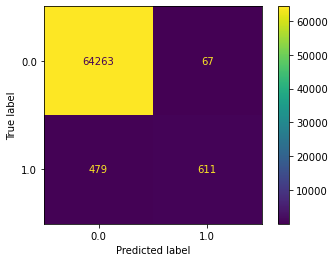

In [90]:
from sklearn.metrics import plot_confusion_matrix

# Plot a confusion matrix for the test set
_ = plot_confusion_matrix(rfc_test, data_test, target_test)
#_ = plot_confusion_matrix(rfc_all, data_full, target_full)

In [91]:
from sklearn.metrics import balanced_accuracy_score

# Perform balanced accuracy test on the ground truth test target and the test predictions
balanced_accuracy_test = balanced_accuracy_score(target_test, test_predictions)
#balanced_accuracy_all = balanced_accuracy_score(target_full, full_predictions)
print(f"Balanced accuracy test: {balanced_accuracy_test:.3f}")
#print(f"Balanced accuracy full: {balanced_accuracy_all:.3f}")

Balanced accuracy test: 0.780


In [92]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
print(precision, recall)

0.9011799410029498 0.5605504587155963


In [258]:
# Balanced accuracy test for dummy classifier (will always be 0.5)
#from sklearn.dummy import DummyClassifier

#dummy_classifier = DummyClassifier(strategy="most_frequent")
#dummy_classifier.fit(data_train, target_train)
#test_predictions = dummy_classifier.predict(data_train)

#balanced_accuracy = balanced_accuracy_score(target_train, test_predictions)
#print(f"Balanced accuracy: {balanced_accuracy:.3f}")

In [76]:
# Post process the ML predictions by reassigning positive and negative detections if a moving average if above or
# below a certain value
summed_100_window_cutoff = 20
summed_100_window_threshold = 50
ones_to_zeros = []
tp = pd.Series(test_predictions)
tp.columns = ['test_predictions']
for i in range(len(tp)):
    if tp[i] == 1 and tp[i - 50: i + 50].sum() < summed_100_window_cutoff:
        tp[i] = 0
        ones_to_zeros.append(i)
    if tp[0] == 0 and tp[i - 50: i + 50].sum() > summed_100_window_threshold and ones_to_zeros.count(i) == 0:
        tp[i] = 1

In [77]:
# Make a list out of each of the frames in which retrieval is occurring based on annotations
tt = pd.DataFrame(target_test)
tt.columns = ['target_test']
tt[tt['target_test'] == 1].index.to_list()

[23626,
 23627,
 23628,
 23629,
 23630,
 23631,
 23632,
 23633,
 23634,
 23635,
 23636,
 23637,
 23638,
 23639,
 23640,
 23641,
 23642,
 23643,
 23644,
 23645,
 23646,
 23647,
 23648,
 23649,
 23650,
 23651,
 23652,
 23653,
 23654,
 23655,
 23656,
 23657,
 23658,
 23659,
 23660,
 23661,
 23662,
 23663,
 23664,
 23665,
 23666,
 23667,
 23668,
 23669,
 23670,
 23671,
 23672,
 23673,
 23674,
 23675,
 23676,
 23677,
 23678,
 23679,
 23680,
 23681,
 23682,
 23683,
 23684,
 23685,
 23686,
 23687,
 23688,
 23689,
 23690,
 23691,
 23692,
 23693,
 23694,
 23695,
 23696,
 23697,
 23698,
 23699,
 23700,
 23701,
 23702,
 23703,
 23704,
 23705,
 23706,
 23707,
 23708,
 23709,
 23710,
 23711,
 23712,
 23713,
 23714,
 23715,
 23716,
 23717,
 23718,
 23719,
 23720,
 23721,
 23722,
 23723,
 23724,
 23725,
 23726,
 23727,
 23728,
 23729,
 23730,
 23731,
 23732,
 23733,
 23734,
 23735,
 23736,
 23737,
 23738,
 23739,
 23740,
 23741,
 23742,
 23743,
 23744,
 23745,
 23746,
 23747,
 23748,
 23749,
 23750,


In [132]:
# Find the number of frames for which there is a false negative prediction by the post-processed model predictions
count = 1
for i in range(len(tp)):
    if tp[i] == 0 and target_test[i] == 1:
        print(i, 'true', count)
        count +=1

23626 true 1
23627 true 2
23628 true 3
23629 true 4
23630 true 5
23631 true 6
23632 true 7
23633 true 8
23634 true 9
23635 true 10
23636 true 11
23637 true 12
23638 true 13
23639 true 14
23640 true 15
23641 true 16
23642 true 17
23643 true 18
23644 true 19
23645 true 20
23646 true 21
23647 true 22
23648 true 23
23649 true 24
23650 true 25
23651 true 26
23652 true 27
23653 true 28
23654 true 29
23655 true 30
23656 true 31
23657 true 32
23658 true 33
23659 true 34
23660 true 35
23661 true 36
23662 true 37
23663 true 38
23664 true 39
23665 true 40
23666 true 41
23667 true 42
23668 true 43
23669 true 44
23670 true 45
23671 true 46
23672 true 47
23673 true 48
23674 true 49
23675 true 50
23676 true 51
23677 true 52
23678 true 53
23679 true 54
23680 true 55
23681 true 56
23682 true 57
23683 true 58
23684 true 59
23685 true 60
23686 true 61
23687 true 62
23688 true 63
23689 true 64
23690 true 65
23691 true 66
23692 true 67
23693 true 68
23694 true 69
23695 true 70
23696 true 71
23697 true 72
2

In [79]:
# New balanced accuracy after post-processing
balanced_accuracy = balanced_accuracy_score(target_test, tp)
print(f"Balanced accuracy: {balanced_accuracy:.3f}")

Balanced accuracy: 0.787


In [119]:
# Find the places in the ground truth annotations that retrieve starts and ends
retrieve_starts = []
retrieve_ends = []
retrieve_videonames = []
for i in range(len(tt)):
    if i == 0 or i == len(tt) - 1:
        continue
    else:
        if tt['target_test'][i] == 1 and tt['target_test'][i - 1] == 0:
            retrieve_starts.append(i)
            retrieve_videonames.append(cat_test_videonames['videonames'][i])
        if tt['target_test'][i] == 1 and tt['target_test'][i + 1] == 0:
            retrieve_ends.append(i)
        
print(retrieve_starts, retrieve_ends)

[23626, 43288, 47609, 56032, 56678] [23847, 43535, 47769, 56241, 56926]


In [120]:
retrieve_videonames

['targets_inserted\\Gal_49_virginfemale_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_50_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv',
 'targets_inserted\\Ucn3_54_father_retreive_trial_1.csv']

Text(0.5, 0.98, 'Model Predictions vs. Labeled Retrievals (Post Processing)')

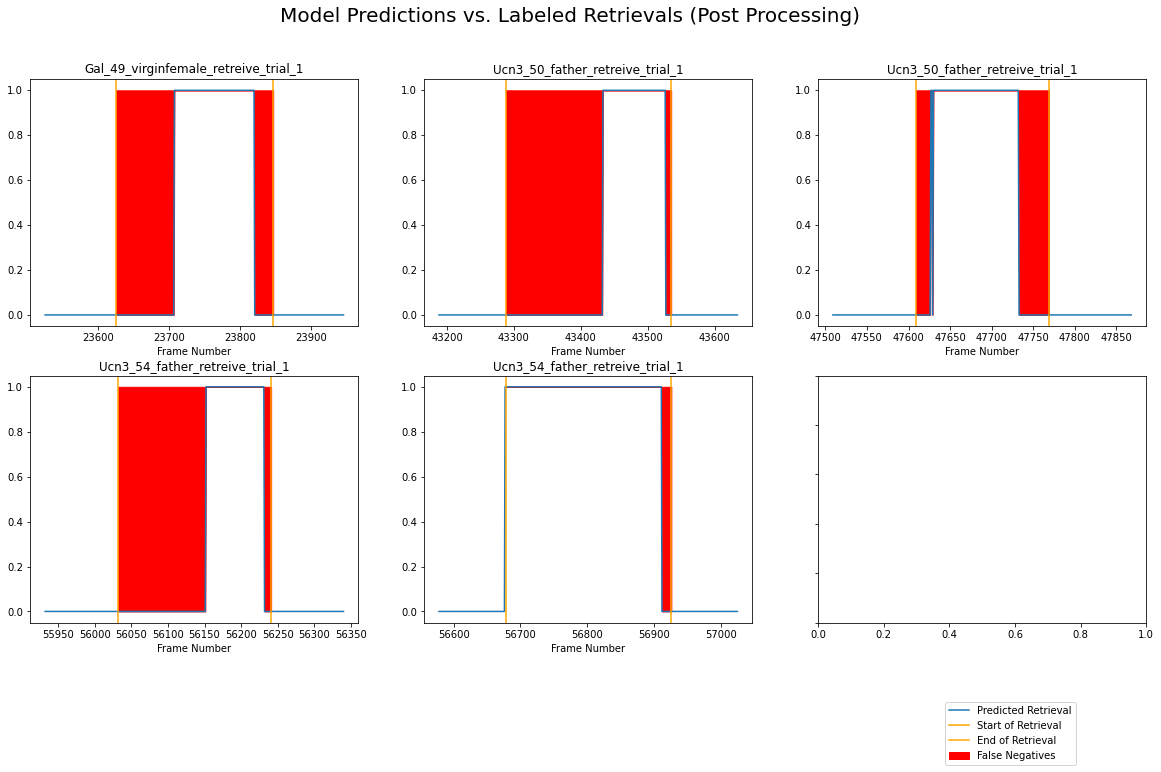

In [155]:
# Plot the test predictions against the ground truth annotations, and fill in any missing frames (false negatives)
# with red
plt.subplots(2, 3, sharey=True, figsize=(20,10))
count = 1
for i in range(len(retrieve_starts)):
    plt.subplot(2, 3, count)
    x_range = range(retrieve_starts[i] - 100, retrieve_ends[i] + 100)
    x_list = list(x_range)
    retrieve_range = (range(retrieve_starts[i], retrieve_ends[i] + 1))
    retrieve_list = list(retrieve_range)
    plt.plot(x_list, tp[retrieve_starts[i] - 100: retrieve_ends[i] + 100], label='Predicted Retrieval')
    plt.axvline(retrieve_starts[i], label='Start of Retrieval', color='orange')
    plt.axvline(retrieve_ends[i], label='End of Retrieval', color='orange')
    plt.fill_between(retrieve_list, tp[retrieve_starts[i]: retrieve_ends[i] + 1], 1, color='red', label='False Negatives')
    plt.title(retrieve_videonames[i][17:-4])
    plt.xlabel('Frame Number')
    if i == 4:
        plt.legend(bbox_to_anchor=(2, -0.3))
    count += 1
plt.suptitle('Model Predictions vs. Labeled Retrievals (Post Processing)', fontsize=20)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.2s finished


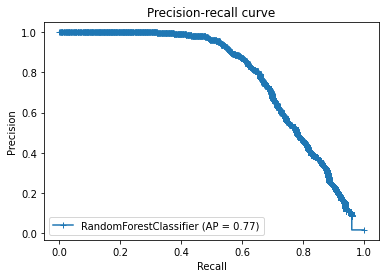

In [85]:
# Calculate a precision recall curve for the rfc model
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import (precision_recall_curve,
                              PrecisionRecallDisplay)

disp = plot_precision_recall_curve(
    rfc_test, data_test, target_test,
    marker="+"
)
disp.figure_
_ = disp.ax_.set_title("Precision-recall curve")

In [130]:
precision = precision_score(tt['target_test'], tp)
recall = recall_score(tt['target_test'], tp)
print(precision, recall)

0.9984051036682615 0.5743119266055046


# Repeat of postprocessing script if the full data is tested against itself

In [160]:
summed_100_window_cutoff = 20
summed_100_window_threshold = 50
ones_to_zeros = []
fp = pd.Series(full_predictions)
fp.columns = ['test_predictions']
for i in range(len(fp)):
    if fp[i] == 1 and fp[i - 50: i + 50].sum() < summed_100_window_cutoff:
        fp[i] = 0
        ones_to_zeros.append(i)
    if fp[0] == 0 and fp[i - 50: i + 50].sum() > summed_100_window_threshold and ones_to_zeros.count(i) == 0:
        fp[i] = 1

In [161]:
tf = pd.DataFrame(target_full)
tf.columns = ['target_full']

In [162]:
balanced_accuracy = balanced_accuracy_score(target_full, fp)
print(f"Balanced accuracy: {balanced_accuracy:.3f}")

Balanced accuracy: 0.859


In [164]:
retrieve_starts = []
retrieve_ends = []
for i in range(len(tf)):
    if i == 0 or i == len(tf) - 1:
        continue
    else:
        if tf['target_full'][i] == 1 and tf['target_full'][i - 1] == 0:
            retrieve_starts.append(i)
        if tf['target_full'][i] == 1 and tf['target_full'][i + 1] == 0:
            retrieve_ends.append(i)
print(retrieve_starts, retrieve_ends)

[2532, 3419, 34841, 63499, 80804, 93151, 101319, 125985, 145647, 149968, 158391, 159037] [2625, 3523, 34971, 63596, 81202, 93256, 101488, 126206, 145894, 150128, 158600, 159285]


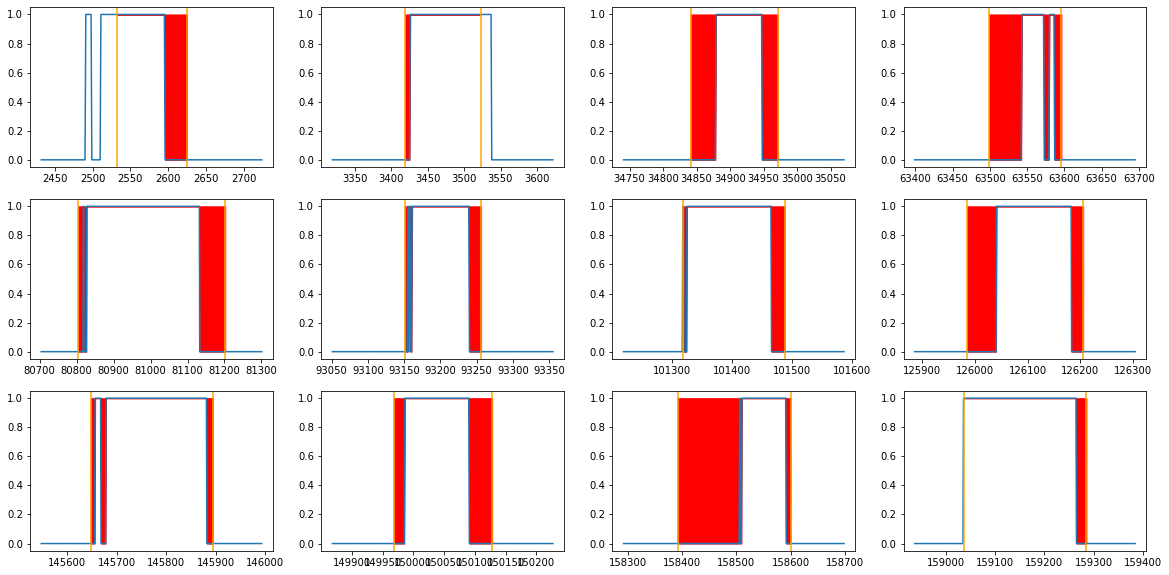

In [171]:
plt.subplots(3, 4, sharey=True, figsize=(20,10))
count = 1
for i in range(len(retrieve_starts)):
    plt.subplot(3, 4, count)
    x_range = range(retrieve_starts[i] - 100, retrieve_ends[i] + 100)
    x_list = list(x_range)
    retrieve_range = (range(retrieve_starts[i], retrieve_ends[i] + 1))
    retrieve_list = list(retrieve_range)
    plt.plot(x_list, fp[retrieve_starts[i] - 100: retrieve_ends[i] + 100])
    plt.axvline(retrieve_starts[i], label='Start of Retrieval', color='orange')
    plt.axvline(retrieve_ends[i], label='End of Retrieval', color='orange')
    plt.fill_between(retrieve_list, fp[retrieve_starts[i]: retrieve_ends[i] + 1], 1, color='red')
    count += 1

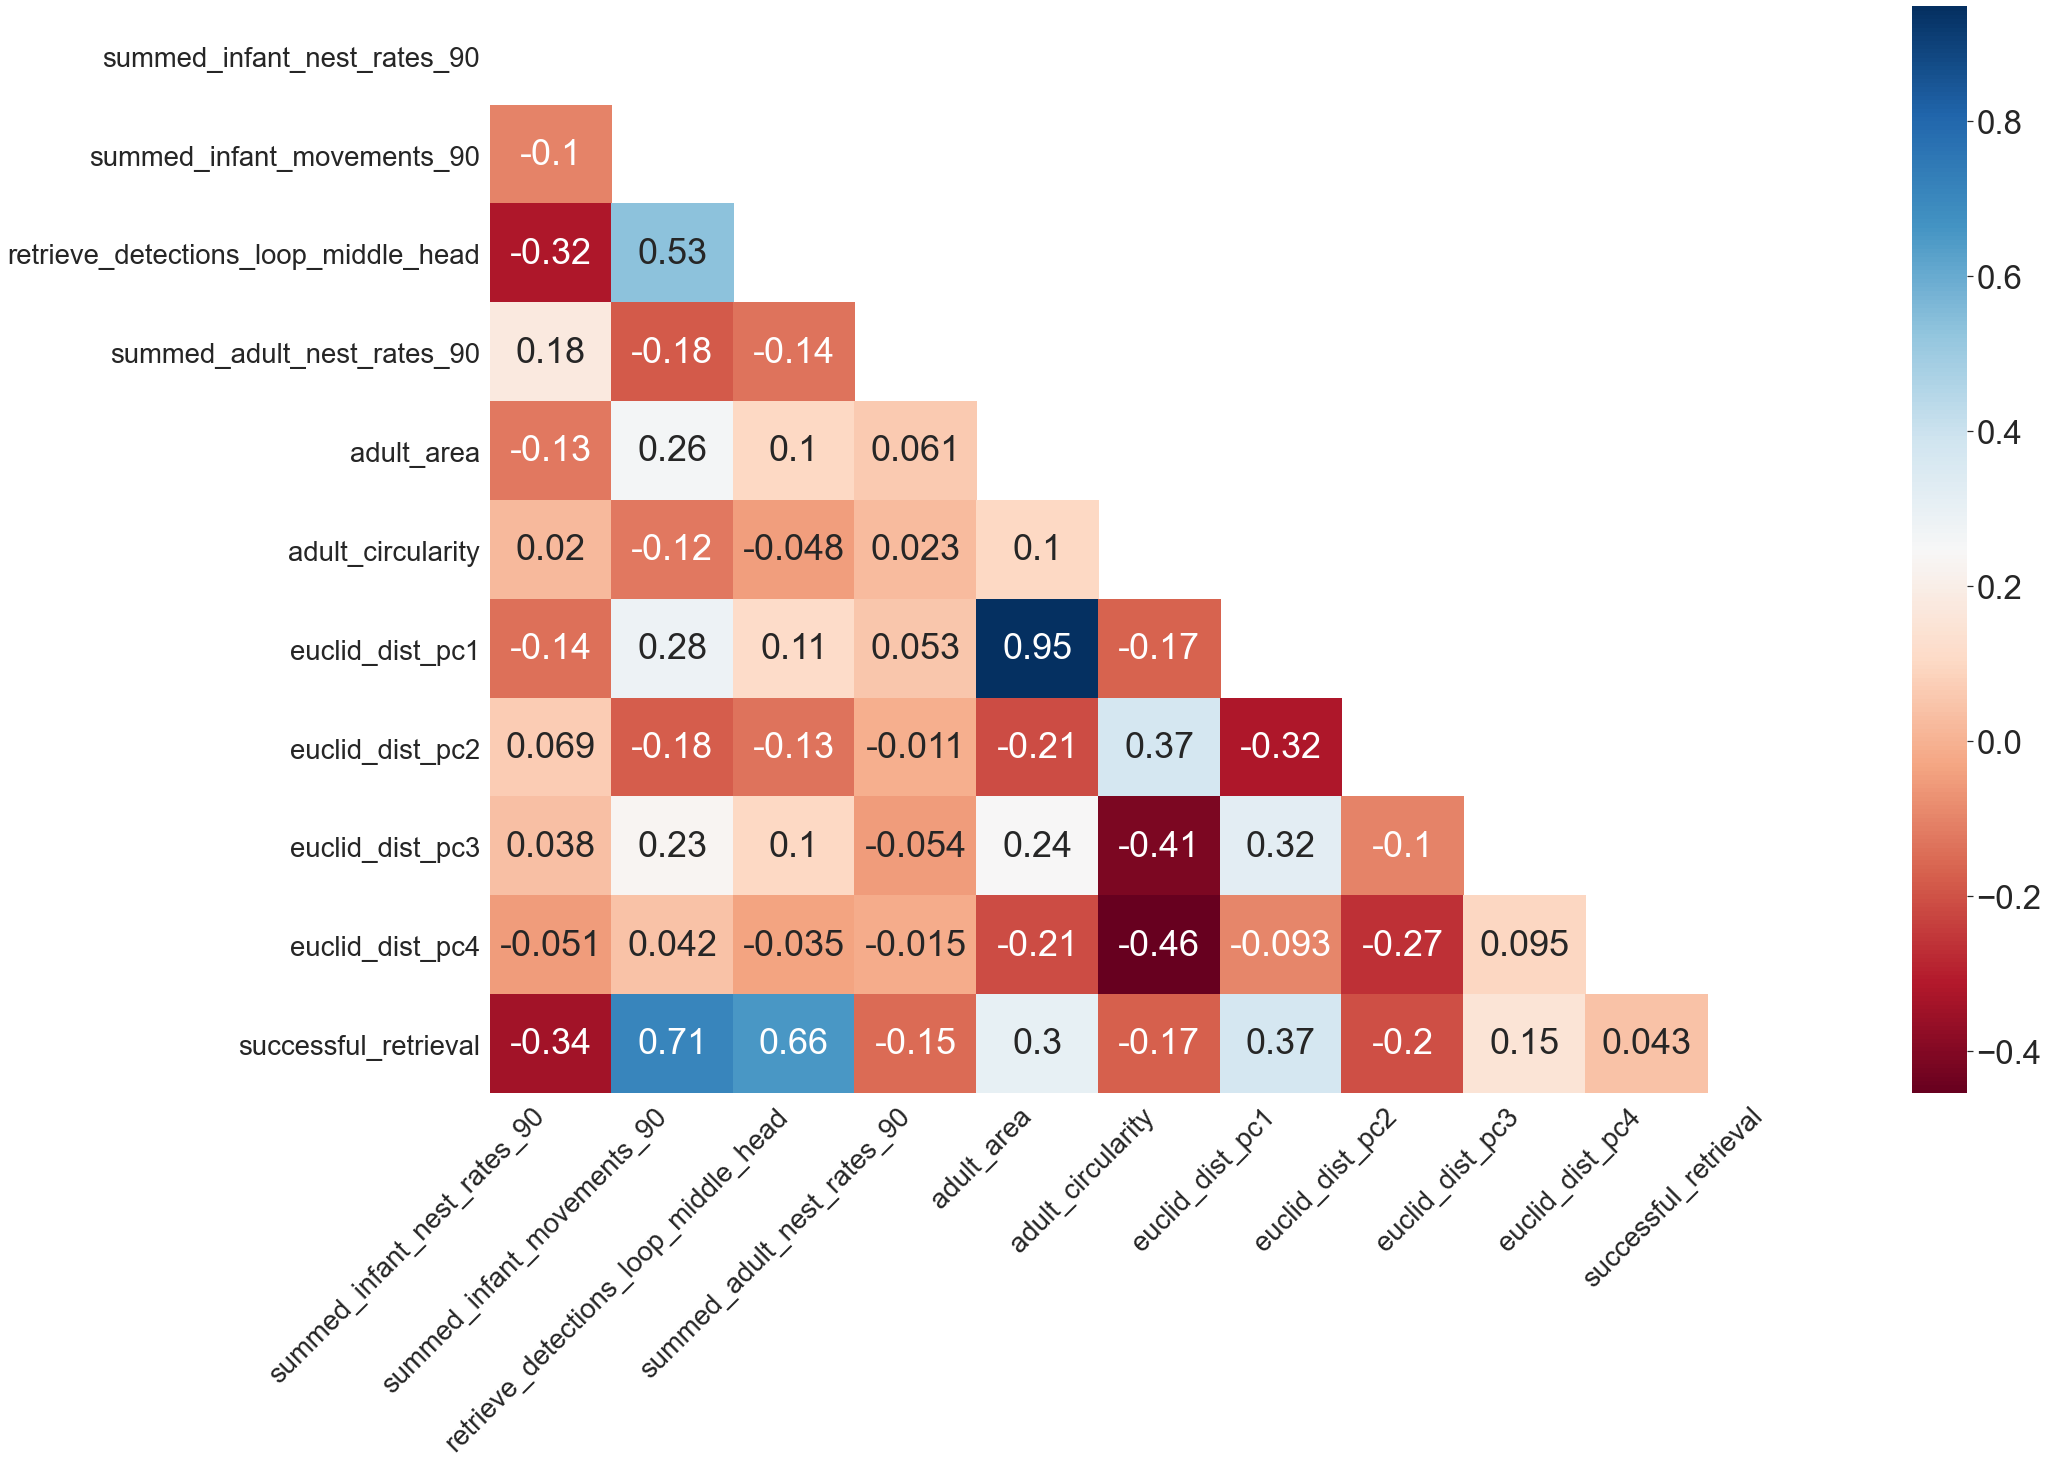

In [37]:
# Plot a correlation matrix for the features and annotations
plt.figure(figsize=(30,20))
ax = plt.axes()
correlation = (features_df.corr())
sns.set(font_scale=3)
fig = sns.heatmap(correlation, cmap='RdBu', annot=True, mask=np.triu(np.ones_like(correlation, dtype=bool)))
fig.set_xticklabels(fig.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_facecolor("white")

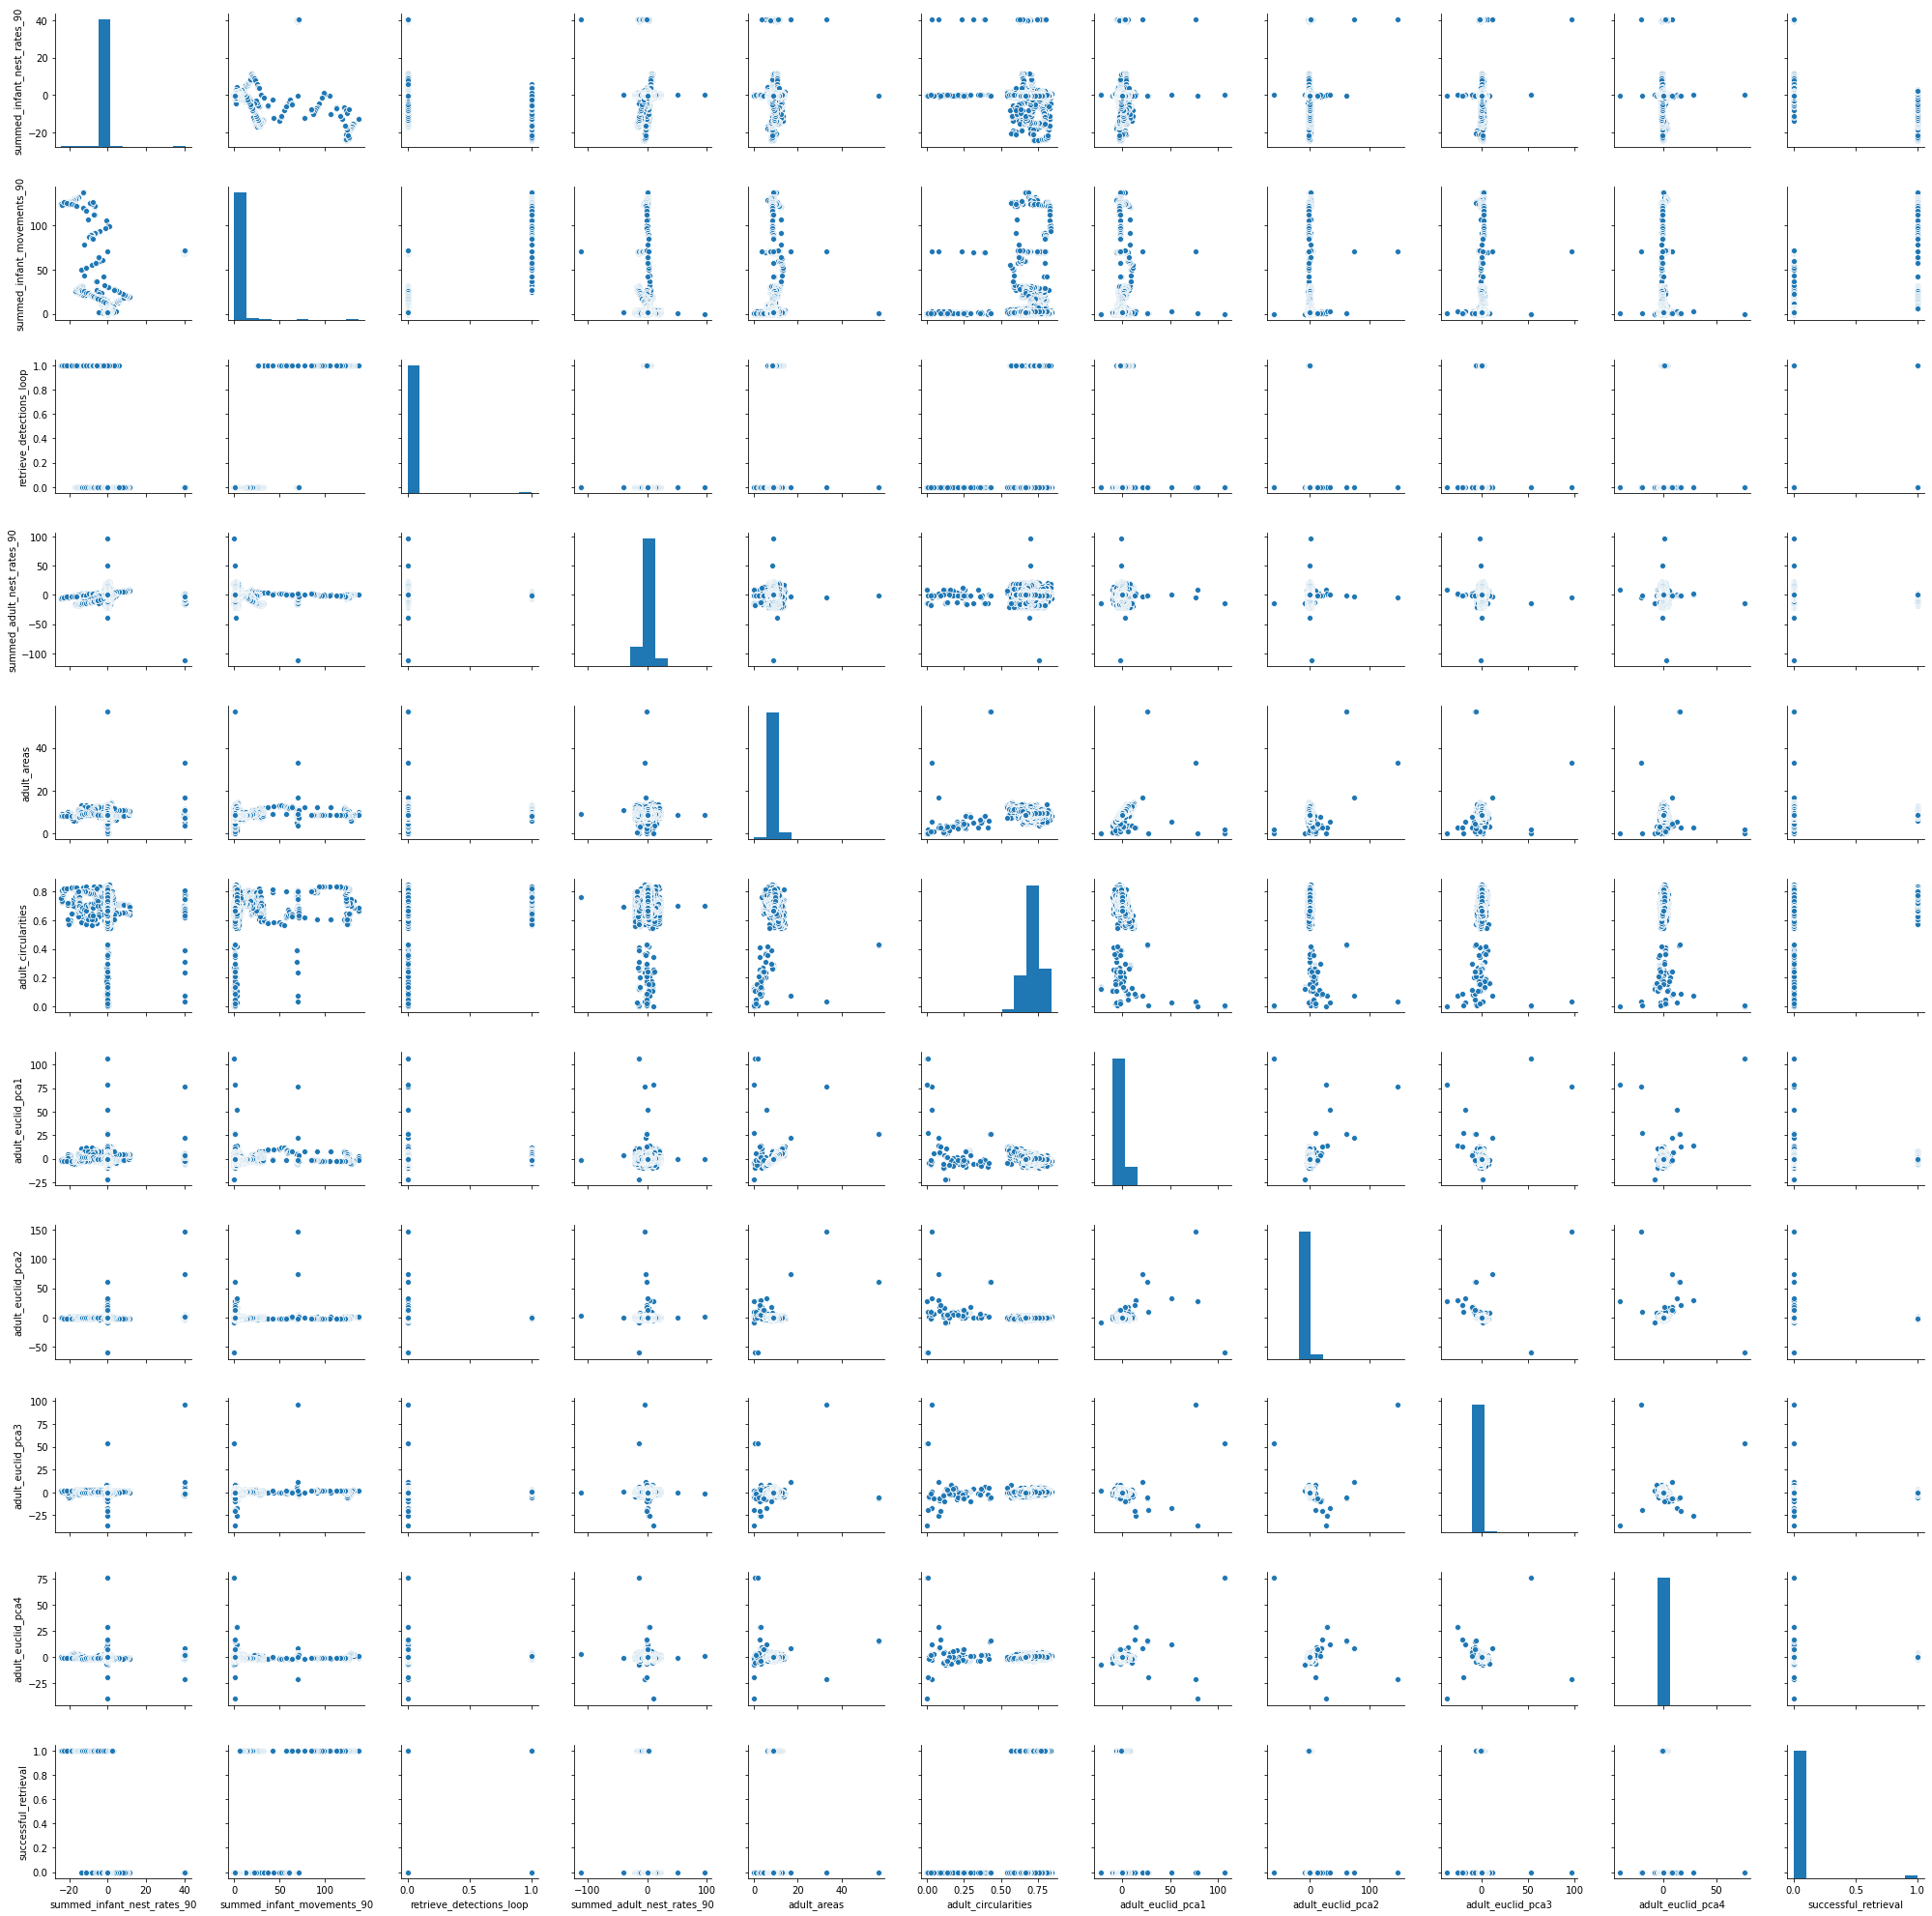

In [15]:
# sns pairplot
sns.pairplot(features_df)

In [16]:
# Make a pandas profiling report
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

df = pd.DataFrame(np.random.rand(100, 5), columns=["a", "b", "c", "d", "e"])
profile = ProfileReport(features_df, title="Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# Save the report as an html file
profile.to_file("pandas_profile_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]